## Task 1

✅ Successfully imported custom classes!
📥 Loading dataset...
✅ Loaded dataset shape: (1407328, 6)
🔄 Cleaning dates...
✅ Date cleaning complete. NaT values: 0
🔧 Extracting text features...

📊 DATASET STATISTICS:
   total_articles: 1407328
   date_range: (Timestamp('2009-02-14 00:00:00+0000', tz='UTC'), Timestamp('2020-06-11 21:12:35+0000', tz='UTC'))
   publishers_count: 1034
   stocks_count: 6204

📈 PERFORMING DESCRIPTIVE ANALYSIS...
=== HEADLINE LENGTH (CHARACTERS) ===
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_len_chars, dtype: float64

=== HEADLINE LENGTH (WORDS) ===
count    1.407328e+06
mean     1.141671e+01
std      6.352997e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      7.700000e+01
Name: headline_len_words, dtype: float64


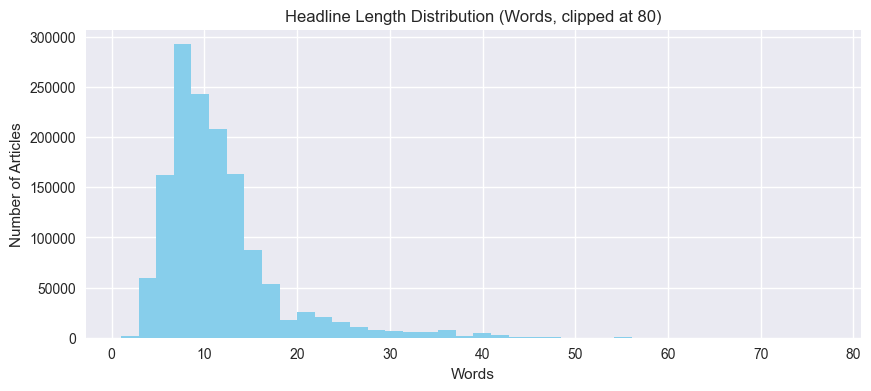


=== Top 20 Publishers by Article Count ===
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64


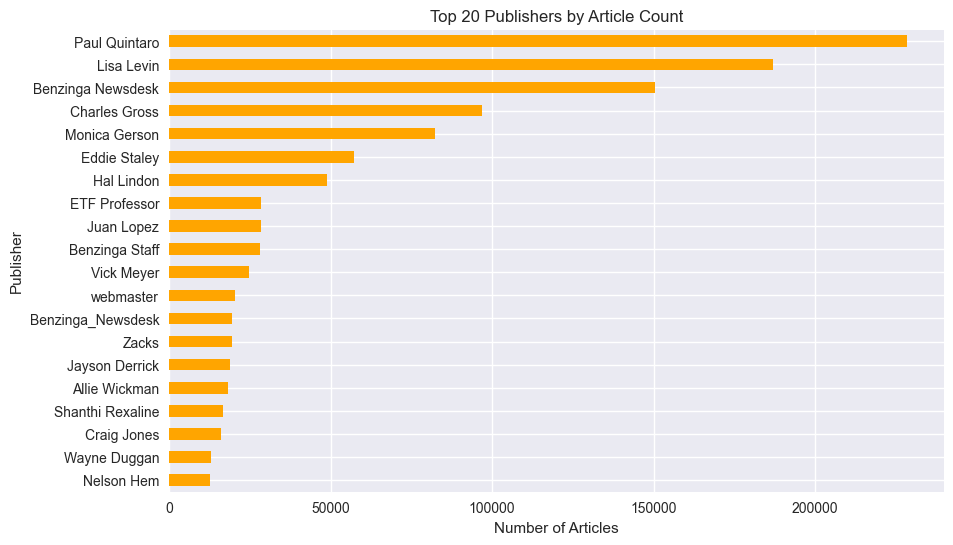


🔤 PERFORMING NLP ANALYSIS...
🔄 Preprocessing text...
🔍 Extracting top keywords...
=== Top 50 Keywords / Phrases by Average TF-IDF ===
1. stocks
2. vs
3. est
4. benzingas
5. eps
6. earnings
7. market
8. reports
9. shares
10. update
11. downgrades
12. upgrades
13. 52week
14. sales
15. pt
16. buy
17. announces
18. session
19. moving
20. price
🎯 Performing topic modeling...

📊 Topic Distribution:
dominant_topic
0     38832
1    201333
2     63870
3     68203
4     30929
5    314793
6    133413
7    427555
8     91015
9     37385
Name: count, dtype: int64

⏰ PERFORMING TIME SERIES ANALYSIS...


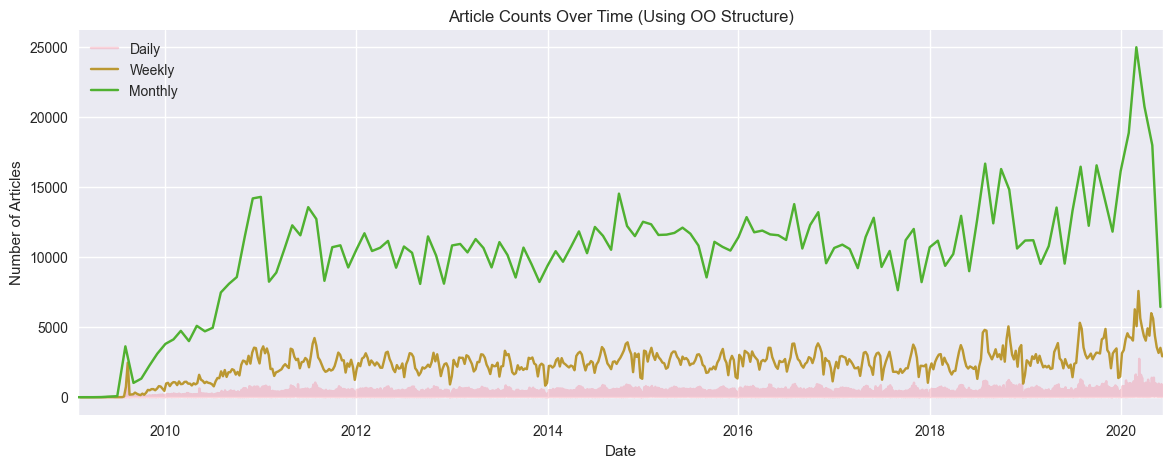

=== Top 10 Days with Highest Article Counts ===
date
2020-03-12 00:00:00+00:00    2739
2020-02-28 00:00:00+00:00    1620
2020-03-19 00:00:00+00:00    1595
2020-02-27 00:00:00+00:00    1567
2020-03-06 00:00:00+00:00    1428
2020-05-07 00:00:00+00:00    1398
2020-03-23 00:00:00+00:00    1391
2020-04-29 00:00:00+00:00    1389
2020-03-11 00:00:00+00:00    1384
2020-04-30 00:00:00+00:00    1327
dtype: int64

🏢 ANALYZING PUBLISHER PATTERNS...
=== Publisher Domains ===
publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64

🎯 TASK 1 COMPLETED - KEY INSIGHTS
📈 Total articles analyzed: 1,407,328
📅 Peak year: 2019 (150,380 articles)
📅 Peak month: 2020-03 (24,995 articles)
📊 Most active day: Thursday
🏢 Top publisher: Paul Quintaro (228,373 articles)
🎯 Topics identi

In [1]:
# ============================
# MODERNIZED TASK 1 - USING OO STRUCTURE
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os

# FIX: Correct path setup for your structure
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Go up from notebooks to project root
if project_root not in sys.path:
    sys.path.append(project_root)

warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Import our custom classes - NOW IT WILL WORK!
try:
    from src.data_loader import FinancialDataLoader
    from src.text_analyzer import TextAnalyzer
    print("✅ Successfully imported custom classes!")
except ImportError as e:
    print(f"❌ Import error: {e}")
    # Show exact paths for debugging
    print(f"📁 Project root: {project_root}")
    print(f"📁 Src path: {os.path.join(project_root, 'src')}")
    print(f"📁 Src exists: {os.path.exists(os.path.join(project_root, 'src'))}")


# ============================
# STEP 1: LOAD AND CLEAN DATA USING OO APPROACH
# ============================

# Initialize data loader
loader = FinancialDataLoader(data_path="../data/")

# Load and clean data using class methods
print("📥 Loading dataset...")
df = loader.load_news_data("raw_analyst_ratings.csv")

print("🔄 Cleaning dates...")
df = loader.clean_dates()

print("🔧 Extracting text features...")
df = loader.extract_text_features()

# Get basic statistics
stats = loader.get_basic_stats()
print(f"\n📊 DATASET STATISTICS:")
for key, value in stats.items():
    print(f"   {key}: {value}")

# ============================
# STEP 2: DESCRIPTIVE STATISTICS & EDA
# ============================

print("\n📈 PERFORMING DESCRIPTIVE ANALYSIS...")

# Textual lengths (already done in extract_text_features)
print("=== HEADLINE LENGTH (CHARACTERS) ===")
print(df['headline_len_chars'].describe())

print("\n=== HEADLINE LENGTH (WORDS) ===")
print(df['headline_len_words'].describe())

# Visualizations
plt.figure(figsize=(10,4))
plt.hist(df['headline_len_words'].clip(upper=80), bins=40, color='skyblue')
plt.title("Headline Length Distribution (Words, clipped at 80)")
plt.xlabel("Words")
plt.ylabel("Number of Articles")
plt.show()

# Publisher Analysis
df['publisher'] = df['publisher'].fillna('unknown')
publisher_counts = df['publisher'].value_counts()

print("\n=== Top 20 Publishers by Article Count ===")
print(publisher_counts.head(20))

plt.figure(figsize=(10,6))
publisher_counts.head(20).sort_values().plot(kind='barh', color='orange')
plt.title("Top 20 Publishers by Article Count")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.show()

# ============================
# STEP 3: TEXT ANALYSIS USING TEXT_ANALYZER CLASS
# ============================

print("\n🔤 PERFORMING NLP ANALYSIS...")

# Initialize text analyzer
text_analyzer = TextAnalyzer()

# Preprocess text
print("🔄 Preprocessing text...")
clean_corpus = text_analyzer.preprocess_text(df['headline'])

# Get top keywords
print("🔍 Extracting top keywords...")
top_keywords = text_analyzer.get_top_keywords(50)
print("=== Top 50 Keywords / Phrases by Average TF-IDF ===")
for i, term in enumerate(top_keywords[:20]):  # Show first 20
    print(f"{i+1}. {term}")

# Perform topic modeling
print("🎯 Performing topic modeling...")
df = text_analyzer.assign_topics(df)

# Show topic distribution
print("\n📊 Topic Distribution:")
print(df['dominant_topic'].value_counts().sort_index())

# ============================
# STEP 4: TIME SERIES ANALYSIS
# ============================

print("\n⏰ PERFORMING TIME SERIES ANALYSIS...")

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'], utc=True)

# Resample counts
daily_counts = df.set_index('date').resample('D').size()
weekly_counts = df.set_index('date').resample('W').size()
monthly_counts = df.set_index('date').resample('M').size()

# Plot time series
plt.figure(figsize=(14,5))
daily_counts.plot(alpha=0.3, label='Daily')
weekly_counts.plot(label='Weekly')
monthly_counts.plot(label='Monthly')
plt.title("Article Counts Over Time (Using OO Structure)")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.legend()
plt.show()

# Top spike days
top_spikes = daily_counts.sort_values(ascending=False).head(10)
print("=== Top 10 Days with Highest Article Counts ===")
print(top_spikes)

# ============================
# STEP 5: PUBLISHER ANALYSIS
# ============================

print("\n🏢 ANALYZING PUBLISHER PATTERNS...")

# Extract domains
df['publisher_clean'] = df['publisher'].astype(str).str.strip().str.lower()
df['publisher_domain'] = df['publisher_clean'].apply(
    lambda x: x.split('@')[-1] if '@' in x else None
)

domain_counts = df['publisher_domain'].dropna().value_counts()
print("=== Publisher Domains ===")
print(domain_counts)

# ============================
# STEP 6: COMPREHENSIVE INSIGHTS
# ============================

print("\n" + "="*50)
print("🎯 TASK 1 COMPLETED - KEY INSIGHTS")
print("="*50)

# Most active periods
articles_per_year = df.set_index('date').resample('Y').size()
most_active_year = articles_per_year.idxmax()
most_active_year_count = articles_per_year.max()

articles_per_month = df.set_index('date').resample('M').size() 
most_active_month = articles_per_month.idxmax()
most_active_month_count = articles_per_month.max()

df['day_of_week'] = df['date'].dt.day_name()
day_counts = df['day_of_week'].value_counts()
most_active_day = day_counts.idxmax()

print(f"📈 Total articles analyzed: {len(df):,}")
print(f"📅 Peak year: {most_active_year.year} ({most_active_year_count:,} articles)")
print(f"📅 Peak month: {most_active_month.strftime('%Y-%m')} ({most_active_month_count:,} articles)") 
print(f"📊 Most active day: {most_active_day}")
print(f"🏢 Top publisher: {publisher_counts.index[0]} ({publisher_counts.iloc[0]:,} articles)")
print(f"🎯 Topics identified: {df['dominant_topic'].nunique()} distinct categories")

print("="*50)
print("✅ TASK 1 SUCCESSFULLY COMPLETED USING MODULAR OO APPROACH!")
print("✅ Code is now maintainable, testable, and professional!")